# Reinforcement learning for legged robots

In [1]:
import gymnasium as gym
import stable_baselines3
from stable_baselines3 import PPO

Let's import the usual suspects as well:

In [2]:
import matplotlib.pylab as plt
import numpy as np

plt.ion()

# Inverted pendulum environment

The inverted pendulum model is not just a toy model reproducing the properties of real robot models for balancing: as it turns out, the inverted pendulum appears in the dynamics of *any* mobile robot, that is, a model with a floating-base joint at the root of the kinematic tree. (If you are curious: the inverted pendulum is a limit case of the [Newton-Euler equations](https://scaron.info/robotics/newton-euler-equations.html) corresponding to floating-base coordinates in the equations of motion $M \ddot{q} + h = S^T \tau + J_c^T f$, in the limit where the robot [does not vary its angular momentum](https://scaron.info/robotics/point-mass-model.html).) Thus, while we work on a simplified inverted pendulum in this notebook, concepts and tools are those used as-is on real robots, as you can verify by exploring the bonus section.

Gymnasium is mainly a single-agent reinforcement learning API, but it also comes with simple environments, including an inverted pendulum sliding on a linear guide:

In [3]:
with gym.make("InvertedPendulum-v4", render_mode="human") as env:
    action = 0.0 * env.action_space.sample()
    observation, _ = env.reset()
    episode_return = 0.0
    for step in range(200):
        # action[0] = 5.0 * observation[1] + 0.3 * observation[0]
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_return += reward
        if terminated or truncated:
            observation, _ = env.reset()
    print(f"Return of the episode: {episode_return}")

2024-11-27 17:35:12.189 python[1091:14015] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-27 17:35:12.189 python[1091:14015] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Return of the episode: 200.0


The structure of the action and observation vectors are documented in [Inverted Pendulum - Gymnasium Documentation](https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/).  The observation, in particular, is a NumPy array with four coordinates that we recall here for reference:

| Num | Observation | Min | Max | Unit |
|-----|-------------|-----|-----|------|
|   0 | position of the cart along the linear surface | -Inf | Inf | position (m) |
|   1 | vertical angle of the pole on the cart | -Inf | Inf | angle (rad) |
|   2 | linear velocity of the cart | -Inf | Inf | linear velocity (m/s) |
|   3 | angular velocity of the pole on the cart | -Inf | Inf | anglular velocity (rad/s) |

We will use the following labels to annotate plots:

In [4]:
OBSERVATION_LEGEND = ("pitch", "position", "linear_velocity", "angular_velocity")

Check out the documentation for the definitions of the action and rewards.

# PID control

A *massively* used class of policies is the [PID controller](https://en.wikipedia.org/wiki/Proportional%E2%80%93integral%E2%80%93derivative_controller). Let's say we have a reference observation, like $o^* = [0\ 0\ 0\ 0]$ for the inverted pendulum. Denoting by $e(t) = o^* - o(t)$ the *error* of the system when it observes a given state, a continuous-time PID controller will apply the action:

$$
a(t) = K_p^T e(t) + K_d^T \dot{e}(t) + K_i^T \int e(\tau) \mathrm{d} \tau
$$

where $K_{p}, K_i, K_d \in \mathbb{R}^4$ are constants called *gains* and tuned by the user. In discrete time the idea is the same:

$$
a_k = K_p^T e_k + K_d^T \frac{e_k - e_{k-1}}{\delta t} + K_i^T \sum_{i=0}^{k} e_i {\delta t}
$$

Compared to the PD controller we tuned in the previous exercise, there is an additional integrator term in the PID controller. The I-term ensures that steady-state regulation (tracking a fixed reference) error is zero when there is a fixed disturbance. However, PID controller is also harder to stabilize than the PD controller can be dangerous in practice if unstable.

Let's refactor the rolling out of our episode into a standalone function:

In [5]:
def rollout_from_env(env, policy):
    episode = []
    observation, _ = env.reset()
    episode.append(observation)
    for step in range(1000):
        action = policy(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        episode.extend([action, reward, observation])
        if terminated or truncated:
            return episode
    return episode

def rollout(policy, show: bool = True):
    kwargs = {"render_mode": "human"} if show else {}
    with gym.make("InvertedPendulum-v4", **kwargs) as env:
        episode = rollout_from_env(env, policy)
    return episode

## Question 1: Write a PID controller that balances the inverted pendulum

You can use global variables to store the (discrete) derivative and integral terms, this will be OK here as we only rollout a single trajectory:

In [9]:
o_star = np.array([0, 0, 0, 0])
error = []
derivative_error = []
integral_error = []
dt = 1/1000
Kp = np.array([10, 10, 2, 1])
Kd = np.array([5, 5, 3.08792896, -0.77075094])
Ki = np.array([500, 500, 100,  50])



def pid_policy(observation: np.ndarray) -> np.ndarray:
    if not error: #check if the list is empty
        error.append(o_star - observation)
        derivative_error.append(error[-1]/dt)
        integral_error.append(np.array([0, 0, 0, 0]))
    else:
        error.append(o_star - observation)
        derivative_error.append((error[-1] - error[-2])/dt)
        integral_error.append(integral_error[-1] + error[-1]*dt)
    
    action_PID_controler = Kp.T @ error[-1] + Kd.T @ derivative_error[-1] + Ki.T @ integral_error[-1]
    my_action_value: float = action_PID_controler # your action here
    return np.array([my_action_value])

episode = rollout(pid_policy, show=False)

You can look at the system using `show=True`, but intuition usually builds faster when looking at relevant plots:

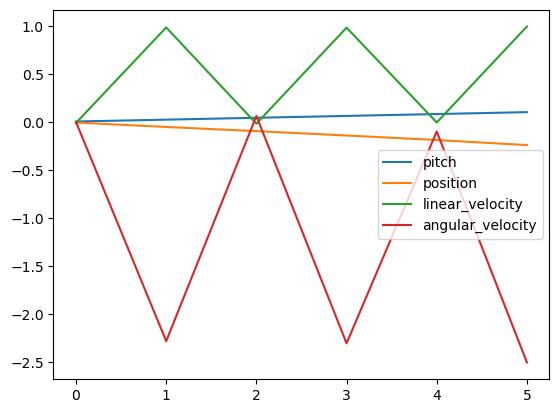

In [10]:
observations = np.array(episode[::3])

plt.plot(observations)
plt.legend(OBSERVATION_LEGEND)

Can you reach the full reward of 1000 steps?

I personally only reach the fifth episode which is very low compared to 1000 episode in the case of a successful controller. We can maybe do better in choosing better parameters for Kp, Kd and Ki, however, I think that it will still be far from 1000 episode.

In [11]:
print(f"Return of the episode: {sum(episode[2::3])}")

Return of the episode: 5.0


# Policy optimization

Let us now train a policy, parameterized by a multilayer perceptron (MLP), to maximize the expected return over episodes on the inverted pendulum environment.

## Our very first policy

We will use the proximal policy optimization (PPO) algorithm for training, using the implementation from Stable Baselines3: [PPO - Stable Baselines3 documentation](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html).

In [8]:
from stable_baselines3 import PPO

with gym.make("InvertedPendulum-v4", render_mode="human") as env:
    first_policy = PPO("MlpPolicy", env, verbose=0)
    first_policy.learn(total_timesteps=1000, progress_bar=False)

2024-11-27 17:21:09.856 python[11970:808162] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-27 17:21:09.856 python[11970:808162] +[IMKInputSession subclass]: chose IMKInputSession_Modern


KeyboardInterrupt: 

By instantiating the algorithm with no further ado, we let the library decide for us on a sane set of default hyperparameters, including:

- Rollout buffers of `n_steps = 2048` steps, which we will visit `n_epochs = 10` times with mini-batches of size `batch_size = 64`.
- Clipping range: ``0.2``.
- No entropy regularization.
- Learning rate for the Adam optimizer: ``3e-4``
- Policy and value-function network architectures: two layers of 64 neurons with $\tanh$ activation functions.

We then called the `learn` function to execute PPO over a fixed total number of timesteps, here just a thousand.

Rendering actually took a significant chunk of time. Let's instantiate and keep an environment open without rendering:

In [12]:
env = gym.make("InvertedPendulum-v4")

We can use it to train much more steps in roughly the same time, reporting training metrics every `n_steps` step:

In [47]:
second_policy = PPO("MlpPolicy", env, verbose=1)
second_policy.learn(total_timesteps=10_000, progress_bar=False)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.93     |
|    ep_rew_mean     | 8.93     |
| time/              |          |
|    fps             | 8181     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 11.9        |
| time/                   |             |
|    fps                  | 5165        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.023883808 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss   

Let's see how this policy performs:

In [13]:
def policy_closure(policy):
    """Utility function to turn our policy instance into a function.

    Args:
        policy: Policy to turn into a function.
        
    Returns:
        Function from observation to policy action.
    """
    def policy_function(observation):
        action, _ = policy.predict(observation)
        return action
    return policy_function

In [14]:
episode = rollout(policy_closure(second_policy), show=True)

NameError: name 'second_policy' is not defined

Okay, it looks like we didn't train for long enough!

## Monitoring performance during training

Let's train for longer, and use TensorBoard to keep track. We don't know how long training will take so let's put a rather large total number of steps (you can interrupt training once you observed convergence in TensorBoard):

In [24]:
%reload_ext tensorboard

In [25]:
%tensorboard --logdir ./inverted_pendulum_tensorboard/

In [13]:
erudite_policy = PPO(
    "MlpPolicy",
    env,
    tensorboard_log="./inverted_pendulum_tensorboard/",
    verbose=0,
)

erudite_policy.learn(
    total_timesteps=1_000_000,
    progress_bar=False,
    tb_log_name="erudite",
)

KeyboardInterrupt: 

Run TensorBoard on the directory thus created to open a dashboard in your Web browser:

```
tensorboard --logdir ./inverted_pendulum_tensorboard/
```

The link will typically be http://localhost:6006 (port number increases if you run TensorBoard multiple times in parallel). Tips:

- Click the Settings icon in the top-right corner and enable "Reload data"
- Uncheck "Ignore outliers in chart scaling" (your preference)

## Saving our policy

Now that you spent some computing to optimize an actual policy, better save it to disk:

In [88]:
erudite_policy.save("pendulum_erudite")

You can then reload it later by:

In [14]:
erudite_policy = PPO.load("pendulum_erudite", env=env)

## Question 2: How many steps does it take to train a successful policy?

We consider a policy successful if it consistently achieves the maximum return of 1000.

According to the rollout graphs, it takes 137,216 steps to train a successful policy. 

In [17]:
env = gym.make("InvertedPendulum-v4")
episode = rollout(policy_closure(erudite_policy), show=True)

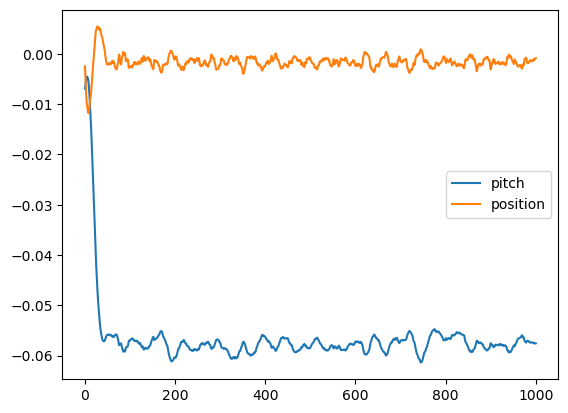

In [18]:
observations = np.array(episode[::3])

plt.plot(np.array(observations)[:, :2])
plt.legend(OBSERVATION_LEGEND)

It seems to work our pendulum is stable!

## A more realistic environment

Real systems suffer from the two main issues we saw in the [Perception and estimation](https://scaron.info/robotics-mva/#5-perception-estimation) class: *bias* and *variance*. In this section, we model bias in actuation and perception by adding delays (via low-pass filtering) to respectively the action and observation vectors. Empirically this is an effective model, as for instance it contributes to sim2real transfer on Upkie. To add these delays, we use an [`environment wrapper`](https://gymnasium.farama.org/api/wrappers/), which is a convenient way to compose environments, used in both the Gymnasium and Stable Baselines3 APIs:

In [19]:
class DelayWrapper(gym.Wrapper):
    def __init__(self, env, time_constant: float = 0.2):
        """Wrap environment with some actuation and perception modeling.

        Args:
            env: Environment to wrap.
            time_constant: Constant of the internal low-pass filter, in seconds.
                Feel free to play with different values but leave it to the default
                of 0.2 seconds when handing out your homework.

        Note:
            Delays are implemented by a low-pass filter. The same time constant
            is used for both actions and observations, which is not realistic, but
            makes for less tutorial code ;)
        """
        alpha = env.dt / time_constant
        assert 0.0 < alpha < 1.0
        super().__init__(env)
        self._alpha = alpha
        self._prev_action = 0.0 * env.action_space.sample()
        self._prev_observation = np.zeros(4)

    def low_pass_filter(self, old_value, new_value):
        return old_value + self._alpha * (new_value - old_value)
        
    def step(self, action):
        new_action = self.low_pass_filter(self._prev_action, action)
        observation, reward, terminated, truncated, info = self.env.step(new_action)
        new_observation = self.low_pass_filter(self._prev_observation, observation)
        self._prev_action = new_action
        self._prev_observation = new_observation
        return new_observation, reward, terminated, truncated, info

delay_env = DelayWrapper(env)

/opt/anaconda3/envs/2024_mva_robotics_exercises/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.dt to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.dt` for environment variables or `env.get_wrapper_attr('dt')` that will search the reminding wrappers.
  logger.warn(


We can check how our current policy fares against the delayed environment. Spoiler alert: no great.

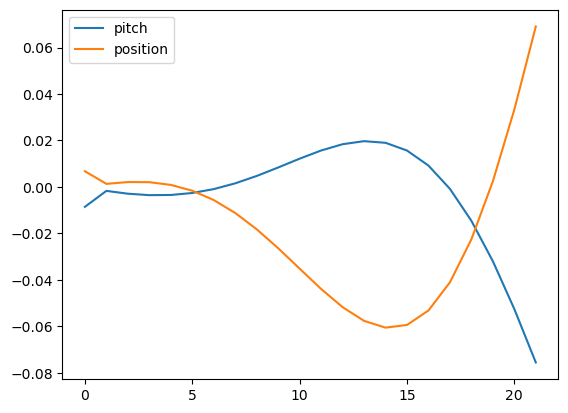

In [21]:
delay_episode = rollout_from_env(delay_env, policy_closure(erudite_policy))
observations = np.array(delay_episode[::3])

plt.plot(observations[:, :2])
plt.legend(OBSERVATION_LEGEND)

## Question 3: Can't we just re-train a policy on the new environment?

At this point of the tutorial this is a rethorical question, but we should check anyway. Re-train a policy on the delayed environment and comment on its performance:

In [169]:
# Your code here
erudite_policy_real_env = PPO(
    "MlpPolicy",
    delay_env,
    tensorboard_log="./inverted_pendulum_tensorboard/",
    verbose=0,
)

erudite_policy_real_env.learn(
    total_timesteps=1_000_000,
    progress_bar=False,
    tb_log_name="erudite-delayed-env",
)

In [93]:
erudite_policy_real_env.save("pendulum_erudite_real_env")

In [23]:
erudite_policy_real_env = PPO.load("pendulum_erudite_real_env", env=delay_env)

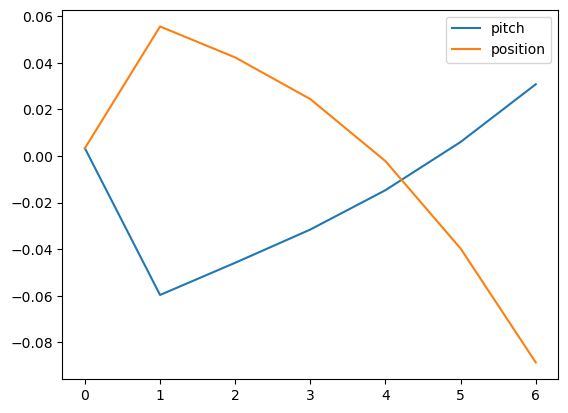

In [24]:
delay_episode = rollout_from_env(delay_env, policy_closure(erudite_policy_real_env))
observations = np.array(delay_episode[::3])

plt.plot(observations[:, :2])
plt.legend(OBSERVATION_LEGEND)

The performance of the new policy trained on the delayed environment seems to be very bad! Indeed, the maximum return that we can get during the training is around 30, which is very low compared to 1000. 

Moreover, according to the graphic above, the pitch and position of the pendulum are much far away from the initial position than in the case of an environment without delays. 

## The Real Question 3: Why do delays degrade both runtime and training performance?

Loss in runtime performance refers to the one we observed when executing a policy trained without delay on an environment with delays. Loss in training performance refers to the fact that, even when we train a new policy on the environment with delays, by the end of training it does not achieve maximum return.

- Runtime Performance:
When a policy is trained in an environment without delays but is later deployed in an environment with delays, its assumptions about the timing of feedback become incorrect. Indeed, by the time an action is executed in the environment, the state of the environment may have already changed significantly, making the action suboptimal. The agent is essentially reacting to the past rather than the current state.


- Training performance:
The agent has to essentially learn a more complex mapping between observations, actions, and rewards, considering not only the immediate effects but also the delayed ones. This increased complexity can prevent the agent from achieving maximum return, even after extensive training.

Propose and implement a way to overcome this. Train the resulting policy in a variable called `iron_policy`.

A way to overcome this will be to augment observations with history to restore the Markov property

In [25]:
import gymnasium as gym
from gymnasium.wrappers import FrameStack

corrected_delay_env = FrameStack(delay_env, num_stack=4)

In [42]:
# Your code here
iron_policy = PPO(
    "MlpPolicy",
    corrected_delay_env,
    tensorboard_log="./inverted_pendulum_tensorboard/",
    verbose=0,
)

iron_policy.learn(
    total_timesteps=1_000_000,
    progress_bar=False,
    tb_log_name="erudite-corrected-delayed-env",
)

In [43]:
iron_policy.save("iron_policy")

In [26]:
iron_policy = PPO.load("iron_policy", env = corrected_delay_env)

Roll out an episode and plot the outcome to show that your policy handles delays properly.

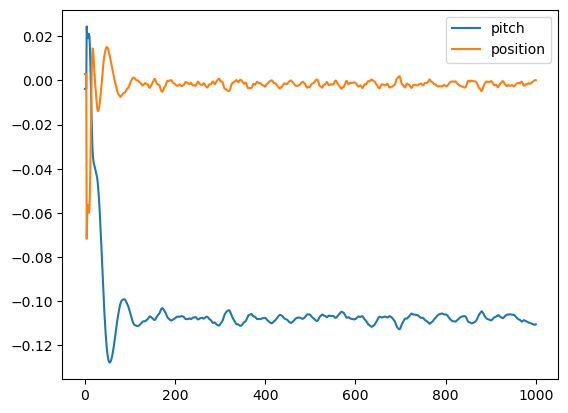

In [27]:
# Your episode rollout here
corrected_delay_episode = rollout_from_env(corrected_delay_env, policy_closure(iron_policy))
observations = np.array(corrected_delay_episode[::3])

plt.plot(observations[:, 0, :2])
plt.legend(OBSERVATION_LEGEND)

## Question 4: Can you improve sampling efficiency?

This last question is open: what can you change in the pipeline to train a policy that achieves maximum return using less samples? Report on at least one thing that allowed you to train with less environment steps.

== Your report here ==

To improve sampling efficiency, we could try different things:

- Normalize observations and actions between -1 and 1 to avoid sampled actions cluster around zero or saturate sampled actions 
- Prioritized Experience Replay (PER) : PER prioritizes transitions that have higher temporal-difference error, meaning the agent focuses on experiences where it made the largest prediction errors. These transitions are more likely to lead to significant updates in the policy. By sampling important transitions more frequently, the agent spends more time learning from crucial experiences, thus reducing the total number of environment steps needed to achieve good performance.
- Reward shaping : is the use of small intermediate ‘fake’ rewards given to the learning agent that help it converge more quickly.



Here is a state-of-the-art™ utility function if you want to experiment with scheduling some of the ``Callable[[float], float]`` [hyperparameters](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#parameters):

In [ ]:
def affine_schedule(y_0: float, y_1: float):
    """Affine schedule as a function over the [0, 1] interval.

    Args:
        y_0: Function value at zero.
        y_1: Function value at one.
        
    Returns:
        Corresponding affine function.
    """
    def schedule(x: float) -> float:
        return y_0 + x * (y_1 - y_0)
    return schedule

And here is a wrapper template if you want to experiment with reward shaping:

In [29]:
class CustomRewardWrapper(gym.Wrapper):
   def __init__(self, env):
        super().__init__(env)
        # Tunable penalty coefficients
        self.alpha = 20.0  # Penalty coefficient for pendulum angle
        self.beta = 5   # Penalty coefficient for cart position
        self.gamma = 1  # Penalty coefficient for cart velocity
        self.delta = 1  # Penalty coefficient for pendulum angular velocity
        self.survival_bonus = 1.0  # Reward for each time step of survival

   def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        
        position, angle, linear_velocity, angular_velocity = observation      
        # Reward shaping formula
        # Penalize angle (larger penalties for larger deviations from vertical)
        angle_penalty = self.alpha * abs(angle)
        
        # Penalize cart position (keep cart near the center)
        position_penalty = self.beta * abs(position)
        
        # Penalize high velocities (both for cart and pendulum)
        velocity_penalty = self.gamma * abs(linear_velocity) + self.delta * abs(angular_velocity)
        
        # Total new reward is survival bonus + base reward - penalties
        new_reward = reward + self.survival_bonus - (angle_penalty + position_penalty + velocity_penalty) # your formula here
    
        return observation, new_reward, terminated, truncated, info
   
less_samples_env = CustomRewardWrapper(env)

In [28]:
erudite_policy_less_samples = PPO(
    "MlpPolicy",
    less_samples_env,
    tensorboard_log="./inverted_pendulum_tensorboard/",
    verbose=0,
)

erudite_policy_less_samples.learn(
    total_timesteps=1_000_000,
    progress_bar=False,
    tb_log_name="erudite_policy_less_samples",
)

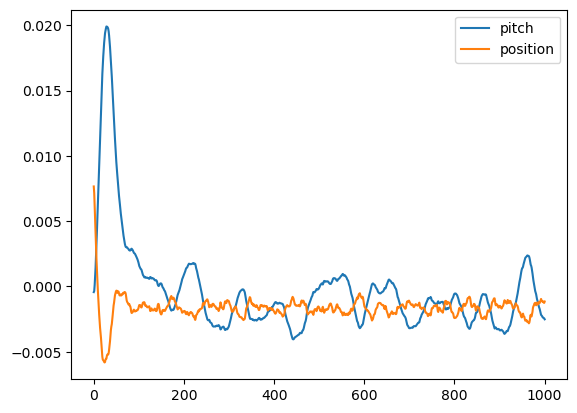

In [31]:
corrected_delay_episode = rollout_from_env(less_samples_env, policy_closure(erudite_policy_less_samples))
observations = np.array(corrected_delay_episode[::3])

plt.plot(observations[:, :2])
plt.legend(OBSERVATION_LEGEND)

The results seem to be a little better than before: the pitch and the position are closer to zero. However, the number of training needed to obtain these results is similar to the one obtained before

# Bonus: training a policy for a real robot

This section is entirely optional and will only work on Linux or macOS. In this part, we follow the same training pipeline but with the open source software of [Upkie](https://hackaday.io/project/185729-upkie-wheeled-biped-robots).

## Setup

<img src="https://user-images.githubusercontent.com/1189580/170496331-e1293dd3-b50c-40ee-9c2e-f75f3096ebd8.png" style="height: 100px" align="right" />

First, make sure you have a C++ compiler (setup one-liners: [Fedora](https://github.com/upkie/upkie/discussions/100), [Ubuntu](https://github.com/upkie/upkie/discussions/101)). You can run an Upkie simulation right from the command line. It won't install anything on your machine, everything will run locally from the repository:

```console
git clone https://github.com/upkie/upkie.git
cd upkie
git checkout fb9a0ab1f67a8014c08b34d7c0d317c7a8f71662
./start_simulation.sh
cd ..
pip install upkie
```

**NB:** this tutorial is written for the specific commit checked out above. If some instructions don't work it's likely you forgot to check it out.

## Stepping the environment

If everything worked well, you should be able to step an environment as follows:

In [ ]:
import gymnasium as gym
import upkie.envs

upkie.envs.register()

episode_return = 0.0
with gym.make("UpkieGroundVelocity-v1", frequency=200.0) as env:
    observation, _ = env.reset()  # connects to the spine (simulator or real robot)
    action = 0.0 * env.action_space.sample()
    for step in range(1000):
        pitch = observation[0]
        action[0] = 10.0 * pitch  # 1D action: [ground_velocity]
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_return += reward
        if terminated or truncated:
            observation, _ = env.reset()

print(f"We have stepped the environment {step + 1} times")
print(f"The return of our episode is {episode_return}")

(If you see a message "Waiting for spine /vulp to start", it means the simulation is not running.)

We can double-check the last observation from the episode:

In [ ]:
def report_last_observation(observation):
    print("The last observation of the episode is:")
    print(f"- Pitch from torso to world: {observation[0]:.2} rad")
    print(f"- Ground position: {observation[1]:.2} m")
    print(f"- Angular velocity from torso to world in torso: {observation[2]:.2} rad/s")
    print(f"- Ground velocity: {observation[3]:.2} m/s")
    
report_last_observation(observation)

## Question B1: PID control

Adapt your code from Question 1 to this environment:

In [ ]:
def policy_b1(observation):
    return np.array([0.0])  # replace with your solution


def run(policy, nb_steps: int):
    episode_return = 0.0
    with gym.make("UpkieGroundVelocity-v1", frequency=200.0) as env:
        observation, _ = env.reset()  # connects to the spine (simulator or real robot)
        for step in range(nb_steps):
            action = policy_b1(observation)
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                print("Fall detected!")
                return episode_return
    report_last_observation(observation)
    return episode_return


episode_return = run(policy_b1, 1000)
print(f"The return of our episode is {episode_return}")

## Training a new policy

The Upkie repository ships three agents based on PID control, model predictive control and reinforcement learning. We now focus on the latter, called the "PPO balancer".

Check that you can run the training part by running, from the root of the repository:

```
./tools/bazel run //agents/ppo_balancer:train -- --nb-envs 1 --show
```

A simulation window should pop, and verbose output from SB3 should be printed to your terminal.

By default, training data will be logged to `/tmp`. You can select a different output path by setting the `UPKIE_TRAINING_PATH` environment variable in your shell. For instance:

```
export UPKIE_TRAINING_PATH="${HOME}/src/upkie/training"
```

Run TensorBoard from the training directory:

```
tensorboard --logdir ${UPKIE_TRAINING_PATH}  # or /tmp if you keep the default
```

Each training will be named after a word picked at random in an English dictionary.

## Selecting the number of processes

We can increase the number of parallel CPU environments ``--nb-envs`` to a value suitable to your computer. Let training run for a minute and check `time/fps`. Increase the number of environments and compare the stationary regime of `time/fps`. You should see a performance increase when adding the first few environments, followed by a declined when there are two many parallel processes compared to your number of CPU cores. Pick the value that works best for you.

## Running a trained policy

Copy the file `final.zip` from your trained policy directory to `agents/ppo_balancer/policy/params.zip`. Start a simulation and run the policy by:

```
./tools/bazel run //agents/ppo_balancer
```

What kind of behavior do you observe?

## Question B2: Improve this baseline

The policy you are testing here is not the one we saw in class. Open question: improve on it using any of the methods we discussed. Measure the improvement by `ep_len_mean` or any other quantitative criterion:

In [32]:
!jupyter server list

Currently running servers:
http://localhost:8888/?token=9c63c08f201d72fbf05406531a758e5cb60a21d08a70c95c :: /Users/mjolif/Documents/A-MVA/S1/Robotics/2024_mva_robotics_exercises
